CS985_1st_Assignment_Regression_Group 7
Student Numbers : 202482083, 202459117, 202482007, 202481426, 202477052


In [2]:
# Import libraries
import pandas as pd, numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Import files
df_train = pd.read_csv('CS98XRegressionTrain.csv')
df_test = pd.read_csv('CS98XRegressionTest.csv')

Part-1 Data cleaning & Transformations
All data transformations applied to the training dataset will also be applied to the test dataset to ensure consistency across all steps.
The Id column is dropped as it lacks predictive value, and the title column is removed due to high variability and noise; TF-IDF modeling added no value.

In [5]:
# Dropping ID because it does not add any predictive value train - TRAIN - TEST
df_train = df_train.drop(columns=['Id','title'])
df_test = df_test.drop(columns=['Id','title'])

One-Hot Encoding (with a 0 limit chosen via trial and error) is used because: (1) Genres/artists are nominal, avoiding false ordinal relationships; (2) Limiting to the top 10 + "Other" prevents high-dimensionality; (3) Grouping rare genres improves generalization; (4) Prioritizes dominant genres; (5) handle_unknown='ignore' prevents test data errors; (6) drop='first' avoids the dummy variable trap; (7) Reduces computational cost by preventing thousands of columns.

In [7]:
# Define how many top genres you want to keep
top_n = 10  # Adjust this as needed
# Get the top N most frequent genres in df_train
top_genres = df_train['top genre'].value_counts().nlargest(top_n).index
# Replace rare genres with "Other" in both train and test sets
df_train['top genre'] = df_train['top genre'].apply(lambda x: x if x in top_genres else 'Other')
df_test['top genre'] = df_test['top genre'].apply(lambda x: x if x in top_genres else 'Other')
# Initialize OneHotEncoder (drop='first' avoids multicollinearity)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
genre_encoded_train = encoder.fit_transform(df_train[['top genre']])
genre_encoded_test = encoder.transform(df_test[['top genre']])
# Convert to DataFrames with proper column names
genre_columns = encoder.get_feature_names_out(['top genre'])
df_genre_train = pd.DataFrame(genre_encoded_train, columns=genre_columns, index=df_train.index)
df_genre_test = pd.DataFrame(genre_encoded_test, columns=genre_columns, index=df_test.index)
# Concatenate with original DataFrames and drop the original "genre" column
df_train = pd.concat([df_train.drop(columns=['top genre']), df_genre_train], axis=1)
df_test = pd.concat([df_test.drop(columns=['top genre']), df_genre_test], axis=1)

In [8]:
# Artist Endocing
top_n = 10  # N of artists
# Get the top N most frequent artists
top_artists = df_train['artist'].value_counts().nlargest(top_n).index
# Replace rare artists with "Other"
df_train['artist'] = df_train['artist'].apply(lambda x: x if x in top_artists else 'Other')
# One-hot encode the filtered 'artist' column
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated for newer scikit-learn
artist_encoded = encoder.fit_transform(df_train[['artist']])  # Now outputs a dense array
# Convert to DataFrame and add column names
artist_encoded_df = pd.DataFrame(artist_encoded, columns=encoder.get_feature_names_out(['artist']))
# Reset index to avoid  issues
df_train = df_train.reset_index(drop=True)
artist_encoded_df = artist_encoded_df.reset_index(drop=True)
# Concatenate back to the DataFrame
df_train = pd.concat([df_train, artist_encoded_df], axis=1).drop(columns=['artist'])
# Artist Encoding - Test Dataset
top_n = 10
# Get the top N most frequent artists
top_artists = df_test['artist'].value_counts().nlargest(top_n).index
# Replace rare artists with "Other"
df_test['artist'] = df_test['artist'].apply(lambda x: x if x in top_artists else 'Other')
# One-hot encode the 'artist' column
encoder = OneHotEncoder(drop='first', sparse_output=False)
artist_encoded = encoder.fit_transform(df_test[['artist']])
# Convert to DataFrame and add column names
artist_encoded_df = pd.DataFrame(artist_encoded, columns=encoder.get_feature_names_out(['artist']))
# Reset index to avoid issues
df_test = df_test.reset_index(drop=True)
artist_encoded_df = artist_encoded_df.reset_index(drop=True)
# Concatenate back to the DataFrame
df_test = pd.concat([df_test, artist_encoded_df], axis=1).drop(columns=['artist'])

In [9]:
# Select only numerical columns
numerical_cols = df_train.select_dtypes(include=['number'])
# Compute skewness and kurtosis
skewness = numerical_cols.skew()
kurtosis = numerical_cols.kurtosis()
# Combine results into a DataFrame
stats_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
#print(stats_df)

Log transformations address skewness by compressing long right tails (e.g., spch = 3.94, live = 2.12) for symmetry. Tree-based models handle skewness well, but optimization was applied. One-hot encoded (0/1) columns weren’t adjusted due to misleading skewness metrics. Near-symmetrical features (e.g., year = -0.23) weren’t transformed to avoid artifacts. Popularity (pop) shows bimodal distribution (20–30, 60–70), so it remains unchanged for interpretability. While tree-based models handle non-linearity, bimodal data may still influence decision boundaries.

In [11]:
# Apply log(1 + x) transformation to the training set and test set
cols_to_transform = ['live', 'spch', 'dur', 'acous']
df_train[cols_to_transform] = df_train[cols_to_transform].apply(lambda x: np.log1p(x))
df_test[cols_to_transform] = df_test[cols_to_transform].apply(lambda x: np.log1p(x))

Outliers are replaced with the mean using IQR, which detects them without assuming normality. This preserves data while reducing extreme value impact. Train-test consistency is ensured by deriving replacements from training data, preventing leakage.

In [13]:
#Outliers Replacement
#import numpy as np
def replace_outliers_with_mean(df_train, df_test):
    # List of columns to replace outliers with the mean
    columns_to_replace = ['bpm', 'dB', 'live', 'dur']
    for col in columns_to_replace:
        if col in df_train.columns:
            # Calculate Q1, Q3, and IQR for outlier detection with train set of bounds
            Q1 = df_train[col].quantile(0.25)
            Q3 = df_train[col].quantile(0.75)
            IQR = Q3 - Q1
            # Define the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Find outliers in the training set
            outliers_train = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
            # Replace outliers with the mean of the column in the train set
            df_train[col] = np.where((df_train[col] < lower_bound) | (df_train[col] > upper_bound),
                                     df_train[col].mean(), df_train[col])
            # Find outliers after replacing in the train set
            outliers_after_train = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
            # Apply the same bounds to the test set
            # Replace outliers in the test set with the mean from the train set (same bounds)
            outliers_test = df_test[(df_test[col] < lower_bound) | (df_test[col] > upper_bound)]
            df_test[col] = np.where((df_test[col] < lower_bound) | (df_test[col] > upper_bound),
                                    df_train[col].mean(), df_test[col])
            outliers_after_test = df_test[(df_test[col] < lower_bound) | (df_test[col] > upper_bound)]
    return df_train, df_test
df_train, df_test = replace_outliers_with_mean(df_train, df_test)

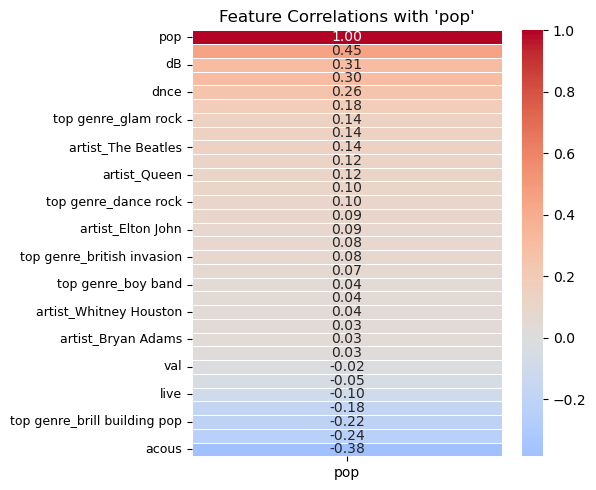

In [14]:
# Check Correlations with pop
corr_matrix = df_train.corr()
# Extract the correlation of all features with the 'pop' feature
pop_corr = corr_matrix['pop'].sort_values(ascending=False)
# Filter correlations (automation for different tests in df_train)
pop_corr_filtered = pop_corr[pop_corr.abs() >= 0]
plt.figure(figsize=(6, 5))  # Compact but readable
sns.heatmap(pop_corr.to_frame(), annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Feature Correlations with 'pop'", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9, rotation=0)  # Keep feature names readable
plt.tight_layout()  # Optimize spacing
plt.show()

Correlations Implications for Modeling:
1) Feature Selection: Strong correlations (e.g., duration, energy, loudness) should be prioritized, while near-zero correlations (e.g., bpm, valence) may have less impact (best performance achieved with all variables) 2) Multicollinearity: Interrelated features (e.g., energy, danceability, loudness) may require multicollinearity checks but aren't problematic for non-linear models. 3) Non-Linearity: Some relationships suggest tree-based models might be more effective than linear regression.
The next step ensures both train and test datasets have the same feature set and column order, preventing errors and ensuring consistent predictions.

In [16]:
# Alignment between columns of train and test dataset
def align_columns(df_train, df_test):
    # Get the columns in both dataframes
    train_columns = set(df_train.columns)
    test_columns = set(df_test.columns)
    # Find columns in df_test that are not in df_train and drop them
    cols_to_drop = test_columns - train_columns
    df_test = df_test.drop(columns=cols_to_drop, errors='ignore')
    # Find columns in df_train that are not in df_test and add them to df_test with NaN values
    cols_to_add = train_columns - set(df_test.columns)
    for col in cols_to_add:
        df_test[col] = 0  # Add new column with NaN values
    # Reorder columns in df_test to match the order of df_train
    df_test = df_test[df_train.columns]
    return df_train, df_test
df_train, df_test = align_columns(df_train, df_test)

**Part 2 Model Development**
These models were chosen for their ability to handle non-linear relationships and complex interactions: 1) Random Forest: Robust, reduces overfitting, and provides feature importance. 2) Extra Trees: Increases randomness, reducing variance. 3) Ensemble Methods: Improve stability by combining model strengths. 4) Voting Regressor: Aggregates predictions, reducing bias and variance. 5) Further details will be provided in individual model comments.

**Random Forest**
Hyparameters: 1) max_features: ['sqrt'] – square root of features prevents overfitting 2) min_samples_split: [5] – Ensures splits occur only when sufficient data supports it, improving generalization. 3) min_samples_leaf: Reduces overfitting by preventing deep splits on small data points. 4) bootstrap: [True] – Uses bootstrapped samples for better generalization.

Performance Evaluation: The RMSE of 10.4899 is reasonable given the range of pop (26 to 84), but it represents an 18.1% error on average, which is a moderate error. The binomial-like distribution of pop could have led to skewed performance.

In [19]:
# Random Forest
# Features (X) and Target (y)
X = df_train.drop(columns=['pop'])
y = df_train['pop']
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [100, 300],  # Fewer trees
    'max_features': ['sqrt'],  # Use 'sqrt' for better speed-performance tradeoff
    'max_depth': [10, 20],  # Limit tree depth
    'min_samples_split': [5],  # Reduce complexity slightly
    'min_samples_leaf': [2, 4],  # Prevent very deep trees
    'bootstrap': [True]}
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)
# Perform Grid Search with Cross-Validation (Reduced to cv=3 for faster training)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
# Best Model Selection
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
# Predict on the test set
y_pred = best_rf.predict(X_test)
# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_rf:.4f}")

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 10.4899


**Extra Trees** Hyperparameters: 1) max_features: Setting this to 'sqrt' introduces diversity in the trees, reducing correlation and improving model performance. 2) max_depth: Testing values like 10, 20, and None ensures a balance between preventing overfitting (by constraining depth) and capturing more complex patterns (with no depth limit).

Performance Evaluation: The RMSE of 10.3253 suggests that the model is performing well, considering the pop range (26 to 84) and its binomial distribution.

In [21]:
#Extra Trees Regressor
# Hyperparameter grid for Extra Trees
param_grid_et = {
    'n_estimators': [100, 300],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3, 5]}
# Initialize Extra Trees Regressor
et_model = ExtraTreesRegressor(random_state=42)
# Perform Grid Search
grid_search_et = GridSearchCV(et_model, param_grid_et, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_et.fit(X_train, y_train)
# Best Model
best_et = grid_search_et.best_estimator_
print(f"Best Parameters (Extra Trees): {grid_search_et.best_params_}")
# Predict
y_pred_et = best_et.predict(X_test)
# RMSE
rmse_et = np.sqrt(mean_squared_error(y_test, y_pred_et))
print(f"RMSE (Extra Trees): {rmse_et:.4f}")

Best Parameters (Extra Trees): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE (Extra Trees): 10.3253


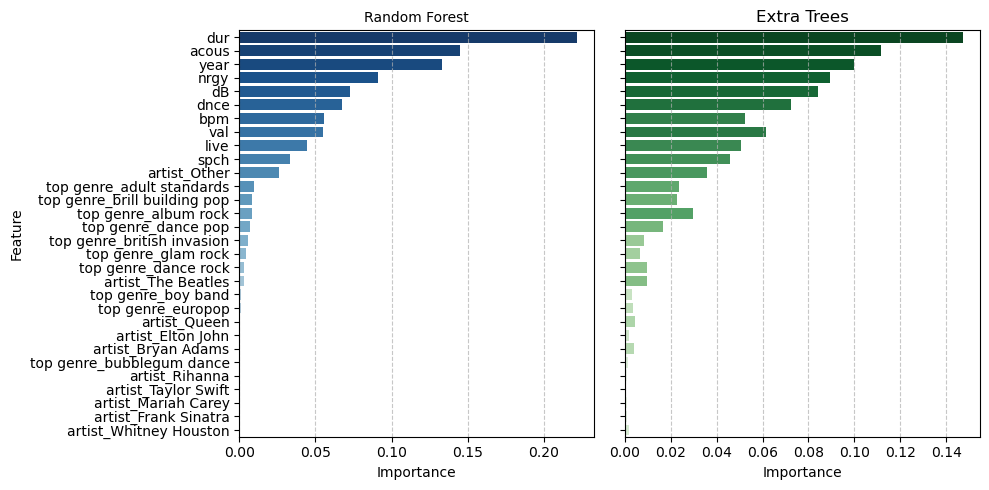

In [22]:
# Feature Importance for Random Forest & Extra Trees
rf_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_rf.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)
et_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_et.feature_importances_})
et_feature_importance = et_feature_importance.sort_values(by='Importance', ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# Random Forest Feature Importance Plot
sns.barplot(x=rf_feature_importance["Importance"], y=rf_feature_importance["Feature"],
            hue=rf_feature_importance["Feature"], palette="Blues_r", ax=axes[0], legend=False)
axes[0].set_title("Random Forest", fontsize=10)
axes[0].set_xlabel("Importance", fontsize=10)
axes[0].set_ylabel("Feature", fontsize=10)
axes[0].grid(axis="x", linestyle="--", alpha=0.7)
# Extra Trees Feature Importance Plot
sns.barplot(x=et_feature_importance["Importance"], y=et_feature_importance["Feature"],
            hue=et_feature_importance["Feature"], palette="Greens_r", ax=axes[1], legend=False)
axes[1].set_title("Extra Trees", fontsize=12)
axes[1].set_xlabel("Importance", fontsize=10)
axes[1].set_ylabel("")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Figure " Feature Importance" Interpretation: Extra Trees’ fully randomized splits encourage capturing a broader range of features, including categorical variables, whereas Random Forest’s deterministic splitting favors the strongest, most stable predictors (mostly numerical). This explains why Extra Trees assigns more importance to genre and artist labels, while Random Forest emphasizes structural song attributes.

**Stacking**
The stacking model has been selected for the following reasons:
1. Diversity in Base Models: Using a combination of two diverse tree-based models (Extra Trees and Random Forest) ensures the model captures different patterns in the data. The randomness of Extra Trees and the robustness of Random Forest work well together.
2. Meta-Model for Optimal Combination: The Ridge Regression meta-model allows for a simple but effective way to combine the predictions of the base models, ensuring the strengths of each base model are leveraged.
3. Improved Performance: By stacking these models, we benefit from their collective performance, leading to better predictive accuracy. The stacking ensemble method typically reduces bias and variance compared to individual models.

The stacking model with an RMSE of 9.80 is a strong candidate and indicates that combining Extra Trees and Random Forest in this manner provides good predictions.

In [25]:
#Stacking model - thats the best
# Define Base Models
base_models = [
    ('et', best_et),
    ('rf',  best_rf) ]
# Define Meta-Model (Ridge Regression to combine the predictions)
meta_model = Ridge(alpha=1.0)
# Create Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)
stacking_regressor.fit(X_train, y_train)
y_pred_stacking = stacking_regressor.predict(X_test)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
print(f"Stacking Regressor RMSE: {rmse_stacking:.4f}")

Stacking Regressor RMSE: 9.7957


**Voting**:
Despite a stacking model using the same base models (Random Forest and Extra Trees), the Voting Regressor serves a distinct purpose and provides valuable insights. since it directly combines the predictions of base models through a simple averaging (soft voting). Additionally, the soft voting method allows for smoother aggregation of predictions
The Voting Regressor's RMSE of 10.3142, while slightly worse than stacking's RMSE of 9.80, confirms that the two ensemble techniques can behave differently in terms of performance, and testing both ensures that we're selecting the most robust strategy for the problem.


In [27]:
# Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('et', best_et)])
voting_regressor.fit(X_train, y_train)
y_pred_voting_soft = voting_regressor.predict(X_test)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting_soft))
print(f"Soft Voting Regressor RMSE: {rmse_voting:.4f}")

Soft Voting Regressor RMSE: 10.3142


In [36]:
y_pred_final = stacking_regressor.predict(df_test.drop(columns='pop'))
output = pd.DataFrame({'Id': pd.read_csv('CS98XRegressionTest.csv')['Id'], 'pop': y_pred_final})
output.to_csv('submission_regression.csv', index=False)

**Evaluation of the models performance on both training and test sets:**

**1)Random Forest (RF)** Training RMSE: 10.49 Test RMSE: 7.78
RF has a significant drop from training to test RMSE, suggesting good generalization. It performs better on the test set due to its ensemble nature, which reduces overfitting. **2) Extra Trees (ET)** Training RMSE: 10.33 Test RMSE: 7.57
ET performs similarly to RF but slightly better on the test set. The greater randomness in its trees helps reduce overfitting and improves performance on unseen data. **3) Stacking Regressor** Training RMSE: 9.80 Test RMSE: 7.05
The stacking model outperforms RF and ET on the test set. By combining RF and ET with a Ridge meta-model, it captures more complex interactions and generalizes well. The lower test RMSE compared to training indicates improved performance due to model diversity. **4) Voting Regressor** Training RMSE: 10.31 Test RMSE: 7.57
The Voting Regressor achieves similar test performance to ET but with a higher training RMSE. It averages predictions from base models, leading to strong generalization without the complexity of a meta-model.

**Comparison and Key Observations**
1. All models show better test performance than training performance, which suggests that ensemble methods like RF, ET, Stacking, and Voting naturally regularize the model, reducing overfitting.
2. Stacking performs the best on the test set (RMSE: 7.05), suggesting it optimally combines base models' strengths.
3. Voting, while simpler, still offers strong test performance (7.57), showing that model diversity helps even without a meta-model.
4. RF and ET are effective at handling noise, and their slight overfitting on the training set doesn't affect their ability to generalize on unseen data.
5. Ensemble regularization reduces variance, helping the models generalize better.
6. Averaging predictions in both stacking and voting leads to lower variance and improved robustness.

To conclude the model with the best performance in train and test data is stacking with RMSE 7.05

Attempts That Didn't Work:
1) Clustering – Weak relationship with pop, no predictive gain. 2) OOB Estimates – No added value; ensemble models already regularized.3) Gender Grouping – Insufficient variance, no meaningful interaction with pop. 4) TF-IDF on Artists – No strong correlation with the target variable. 5) PCA – Reduced interpretability and removed important information. 6)XGBoost, GB, CatBoost, NN – Overfitting or poor feature utilization. 7)Linear Models – Struggled with non-linearity.8)SVM – Inefficient due to scaling sensitivity and handling large, complex features.